In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raimiazeezbabatunde/candle-image-data")

print("Path to dataset files:", path)
import os

class_names = sorted(os.listdir(TRAIN_DIR))
print("Classes:", class_names)

Using Colab cache for faster access to the 'candle-image-data' dataset.
Path to dataset files: /kaggle/input/candle-image-data
Classes: ['Down', 'Up']


In [15]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

TRAIN_DIR = path + "/Train"
TEST_DIR  = path + "/Test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Classes:", train_ds.class_names)


Found 1433 files belonging to 2 classes.
Using 1147 files for training.
Found 1433 files belonging to 2 classes.
Using 286 files for validation.
Found 351 files belonging to 2 classes.
Classes: ['Down', 'Up']


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])


In [17]:
inputs = tf.keras.Input(shape=(128,128,3))

x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)

x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4902 - loss: 0.7029 - val_accuracy: 0.6154 - val_loss: 0.6734
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5628 - loss: 0.6874 - val_accuracy: 0.6154 - val_loss: 0.6797
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5489 - loss: 0.6881 - val_accuracy: 0.6154 - val_loss: 0.6705
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5521 - loss: 0.6883 - val_accuracy: 0.6154 - val_loss: 0.6740
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5468 - loss: 0.6865 - val_accuracy: 0.6189 - val_loss: 0.6678
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5405 - loss: 0.6913 - val_accuracy: 0.6154 - val_loss: 0.6708
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5701 - loss: 0.6828 - val_accuracy: 0.6224 - val_loss: 0.6717
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5419 - loss: 0.6887 - val_accuracy: 0.6154 - val_loss:

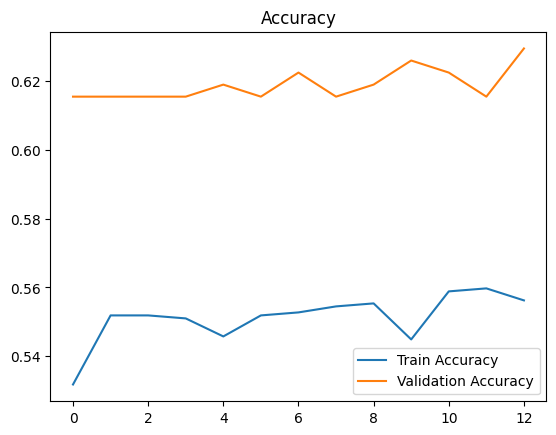

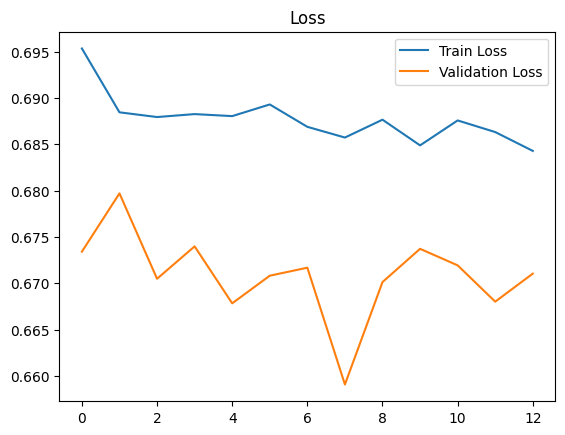

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).flatten()
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((preds >= 0.5).astype(int))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print(classification_report(y_true, y_pred, target_names=train_ds.class_names))


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.2456 - loss: 0.8267
Test accuracy: 0.5498575568199158
Confusion Matrix:
 [[  0 157]
 [  1 193]]


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'